In [2]:
# Imports math library
import numpy as np

# Imports plotting library
import matplotlib.pyplot as plt

# Test convex polygon generation

In [104]:
class Point: 

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, p):
        return np.sqrt((p.x - self.x)**2 + (p.y - self.y)**2)
    
    def __str__(self):
        return f"Point(x={self.x}, y={self.y})"

class Polygon:

    def __init__(self, points):
        """
        :param points: a list of 2-dimensional vectors.
        """

        # Deep copy of the points array. While making the copy we can
        # find the centroid of the polygon

        self.points = []
        for point in points:
            if isinstance(point, Point):
                self.points.append(Point(point.x, point.y))  # copy it
            elif isinstance(point, tuple):
                self.points.append(Point(point[0], point[1]))
            else:
                raise ValueError(f'Invalid object {point}')

    @classmethod
    def generate_random_polygon(cls, num_sides, radius, noise=0.5, merge_near_points=None):

        if num_sides < 3:
            raise ValueError("Number of sides must be at least 3")

        angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)

        # perturbed_points = []
        perturbed_points = {}

        for angle in angles:

            # Perturb the angle with Gaussian noise
            angle += np.random.normal(0, noise)
            angle = angle % (2 * np.pi)

            # Calculate the coordinates for the random point
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)

            # perturbed_points.append((x, y, angle))
            perturbed_points.update({angle: Point(x, y)})

        # Sort the array to have a convex polygon
        # sorted_perturbed_points = sorted(perturbed_points, key=lambda point: point[2])
        points = [perturbed_points[key] for key in sorted(perturbed_points.keys())]

        merged_points = []
        if merge_near_points is not None:
            merged_points.append(points[0])
            for i in range(1, len(points)):
                if points[i].distance(points[i-1]) > merge_near_points:
                    merged_points.append(points[i])

            # If we have more than 2 points
            if len(merged_points) > 2:
                return cls(merged_points)
            else:
                return cls(points)

        else:
            return cls(points)



0.6918915939307888: Point(x=1.5400811320732641, y=1.2759898536555583)
2.4848787344181966: Point(x=-1.5840054282215006, y=1.2210351360074865)
3.6826215044817032: Point(x=-1.714358516453285, y=-1.030036347448036)
4.9623936621022695: Point(x=0.49481699085225883, y=-1.9378225268491218)
6.008536982444769: Point(x=1.9250412689062577, y=-0.5424169180692888)


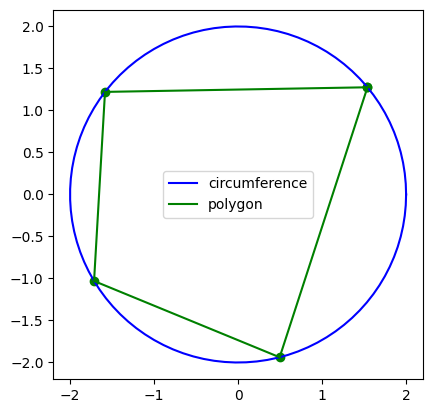

In [98]:
def visualize_ploygon(
        polygon, 
        visualize_points=True, 
        visualize_circumference=True, 
        polygon_color='green',
        circumference_color='blue',
        path=None
    ):

    x = [point.x for point in polygon.points] + [polygon.points[0].x]
    y = [point.y for point in polygon.points] + [polygon.points[0].y]

    fig, ax = plt.subplots()

    # Plot the circumference
    if visualize_circumference:

        r = Point(0, 0).distance(polygon.points[0])
        theta = np.linspace(0, 2*np.pi, 100)

        # Compute x1 and x2
        x_c = r*np.cos(theta)
        y_c = r*np.sin(theta)

        ax.plot(x_c, y_c, color=circumference_color, label='circumference')

    # Plot the polygon
    ax.plot(x, y, color=polygon_color, label='polygon')

    # Scatter the points
    if visualize_points:
        ax.scatter(x, y, color=polygon_color)

    ax.legend()
    ax.set_aspect(1)

    if path is not None:
        plt.savefig(path)
    
    plt.show()

p = Polygon.generate_random_polygon(5, 2, merge_near_points=2)
visualize_ploygon(p)


In [118]:
for point in p.points:
    
    r = Point(0, 0).distance(point)
    theta = np.rad2deg(np.arctan2(point.y, point.x))
    
    print(f'Point({point.x}, {point.y}) at angle {theta % 360}')


Point(0.9214987901023485, -1.7750605566683937) at angle 297.435475173468
Point(0.0846118201988236, 1.9982094084161055) at angle 87.57532625958
Point(-1.6628911689794459, -1.111212382998935) at angle 213.75247790042167
Point(1.3410454710147024, -1.4837779633998325) at angle 312.1074226068056


In [ ]:
# Math
from math import pi, sin, cos
import random

# Geometry
from model.geometry.polygon import Polygon
from model.geometry.point import Point
import model.geometry.utils as utils

# Obstacles
from model.world.map.rectangular_obstacle import RectangularObstacle

# Serialization
import pickle
import json


# random environment parameters
OBS_MIN_DIM = 0.1  # meters
OBS_MAX_DIM = 2.5  # meters
OBS_MIN_COUNT = 10
OBS_MAX_COUNT = 50
OBS_MIN_DIST = 0.4  # meters
OBS_MAX_DIST = 6.0  # meters
GOAL_MIN_DIST = 2.0  # meters
GOAL_MAX_DIST = 4.0  # meters
MIN_GOAL_CLEARANCE = 0.2  # meters


class Map:

    def __init__(self):

        # Initial obstacle position
        self.obstacles = []

        # Current obstacle position
        self.current_obstacles = []

        self.current_goal = None

    def random_map(self, robots):

        # Obstacle parameters
        obs_min_dim = OBS_MIN_DIM
        obs_max_dim = OBS_MAX_DIM
        obs_min_count = OBS_MIN_COUNT
        obs_max_count = OBS_MAX_COUNT
        obs_min_dist = OBS_MIN_DIST
        obs_max_dist = OBS_MAX_DIST

        # Goal parameters
        goal_min_dist = GOAL_MIN_DIST
        goal_max_dist = GOAL_MAX_DIST

        # Generate the goal
        goal_dist_range = goal_max_dist - goal_min_dist
        dist = goal_min_dist + (random.random() * goal_dist_range)
        phi = -pi + (random.random() * 2 * pi)
        x = dist * sin(phi)
        y = dist * cos(phi)
        goal = Point(x, y)

        # Generate a proximity test geometry for the goal
        r = MIN_GOAL_CLEARANCE
        n = 6
        goal_test_geometry = []
        for i in range(n):
            goal_test_geometry.append(
                Point(x + r * cos(i * 2 * pi / n), y + r * sin(i * 2 * pi / n))
            )
        goal_test_geometry = Polygon(goal_test_geometry)

        # Generate the obstacles
        obstacles = []
        obs_dim_range = obs_max_dim - obs_min_dim
        obs_dist_range = obs_max_dist - obs_min_dist
        num_obstacles = random.randrange(obs_min_count, obs_max_count + 1)

        # test_geometries contains the robots and the goal
        test_geometries = [r.body for r in robots] + [
            goal_test_geometry
        ]

        while len(obstacles) < num_obstacles:

            # Generate dimensions
            width = obs_min_dim + (random.random() * obs_dim_range)
            height = obs_min_dim + (random.random() * obs_dim_range)

            # Generate position
            dist = obs_min_dist + (random.random() * obs_dist_range)
            phi = -pi + (random.random() * 2 * pi)
            x = dist * sin(phi)
            y = dist * cos(phi)

            # Generate orientation
            theta = -pi + (random.random() * 2 * pi)

            # Generate velocity
            vel = (0, 0, 0)

            # Test if the obstacle overlaps the robots or the goal.
            # We need to set the velocity vector as (0, 0, 0) to make the object
            # static for the check
            obstacle = RectangularObstacle(width, height, (x, y, theta), vel)
            intersects = False
            for test_geometry in test_geometries:
                intersects |= utils.convex_polygon_intersect_test(
                    test_geometry, obstacle.polygon
                )
            if not intersects:
                obstacles.append(obstacle)

        # Update the velocity vector
        for obstacle in obstacles:
            obstacle.vel = (random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1))

        # Update the obstacles and the goal
        self.current_obstacles = obstacles
        self.obstacles = obstacles
        self.current_goal = goal

    def reset_map(self):
        self.current_obstacles = self.obstacles

    def save_map(self, filename):
        with open(filename, "wb") as file:
            pickle.dump(self.current_obstacles, file)
            pickle.dump(self.current_goal, file)

    def load_map(self, filename):
        with open(filename, "rb") as file:
            self.current_obstacles = pickle.load(file)
            self.current_goal = pickle.load(file)
